# UNet for image quality improvement with Omhu 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import random

import torch

cuda = torch.cuda.is_available()

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
import torch.nn as nn

from torchsummary import summary

#from google.colab import drive
#from google.colab import files

## 1. Loading CIFAR10 dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', download =True, train=True, transform = transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2, pin_memory=cuda)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=True, num_workers=2, pin_memory=cuda)

train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)

Files already downloaded and verified
Files already downloaded and verified


Tensor values range:  tensor(0.) tensor(1.)


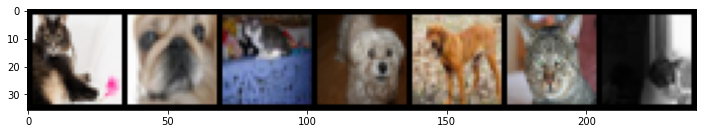

In [ ]:
# Run this cell multiple time to see more samples

def imshow(img, recon=None):
    """ show an image """
    npimg = img.numpy()
    if recon != None: 
      nprecon = recon.detach().numpy()
      fig = plt.figure(figsize=(12, 12))
      ax1 = fig.add_subplot(2,1,1)
      ax1.imshow(np.transpose(npimg, (1, 2, 0)))
      ax2 = fig.add_subplot(2,1,2)
      ax2.imshow(np.transpose(nprecon, (1, 2, 0)))
    else:
      plt.figure(figsize = (12,12))
      plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
images,_ = train_data_iter.next()
print('Tensor values range: ',torch.min(images), torch.max(images))

# show images
imshow(torchvision.utils.make_grid(images[:7]))

### 2. Model: UNet


UNet is a fully convolutional neural network. Its key block consists of: 3x3 convolutions, a rectified linear unit, a 2x2 max pooling operation with a stride 2, which for the encoder is downsampling while, for the decoder, it is upsampling the input images.
In the encoding path, we have been doubling the number of feature channels at each block, while in the deconding path we halved them.

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                   (name + "norm1", nn.BatchNorm2d(num_features=features)),
                   (name + "relu1", nn.ReLU(inplace=True)),
                   (name + "conv2",
                        nn.Conv2d(
                          in_channels=features,
                          out_channels=features,
                          kernel_size=3,
                          padding=1,
                          bias=False,
                      ),
                    ),
                   (name + "norm2", nn.BatchNorm2d(num_features=features)),
                   (name + "relu2", nn.ReLU(inplace=True)),                  
                ]
            )
        )


In [ ]:
model = UNet(in_channels=3, out_channels=3)

if cuda:
    model = model.cuda()

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) 

## 3.Train the network on transformed data

In [ ]:
num_epochs = 50
outputs = []
orig_ims = []
recon_ims = []
train_loss = []
val_loss = []
brightness = transforms.ColorJitter(brightness=2, contrast=0, saturation=0, hue=0)
contrast = transforms.ColorJitter(brightness=0, contrast=1, saturation=0, hue=0)
for epoch in range(num_epochs):
    model.train()
    for (img, _) in trainloader:
        if cuda:
            img = img.cuda()
        if random.uniform(0, 1) < 0.4:
          recon = model(brightness(img))
        if 0.46 < random.uniform(0, 1) < 0.9: 
          recon = model(contrast(img))
        else:
          recon = model(img)  # get the reconstructed image
        loss = criterion(recon, img)   # calculate the MSE between the original image and the reconstructed image
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
     
    train_loss.append(loss.item())    

    # Evaluate gradients
    with torch.no_grad():
      model.eval()
    # Just load a single batch from the test loader
      x, _ = next(iter(testloader))
      if cuda:
        x = x.cuda()
      if random.uniform(0, 1) < 0.5:
        recon_x = model(brightness(x))
      if 0.51 < random.uniform(0, 1) < 1: 
        recon_x = model(contrast(x))

      loss_x = criterion(recon_x, x)
      val_loss.append(loss_x.item())

    print(f'Epoch:{epoch+1}, Loss:{train_loss[-1]:.4f}, Val_Loss:{loss_x.item():.4f}') 
    if epoch == 0:
        continue

    orig_ims.append(img)  
    recon_ims.append(recon)  
    outputs.append((epoch, x, recon_x)) # store the epoch, the image and the reconstructed image in the outputs list
    if  ((len(train_loss)>1) and (train_loss[-1] < min(train_loss[:-1]))): 
       state_dics = model.state_dict()
       print('new_minloss_epoch: ',epoch+1,' with new_min_loss: ', train_loss[-1]) 
    elif len(train_loss)==1:
      state_dics = model.state_dict()

    

torch.save(state_dics, '/content/Trained_model.pth')


Epoch:1, Loss:0.0023, Val_Loss:0.0141
Epoch:2, Loss:0.0015, Val_Loss:0.0225
new_minloss_epoch:  2  with new_min_loss:  0.0014505661092698574
Epoch:3, Loss:0.0010, Val_Loss:0.1705
new_minloss_epoch:  3  with new_min_loss:  0.0009739640518091619
Epoch:4, Loss:0.0003, Val_Loss:0.0383
new_minloss_epoch:  4  with new_min_loss:  0.00030075162067078054
Epoch:5, Loss:0.0006, Val_Loss:0.1159
Epoch:6, Loss:0.0035, Val_Loss:0.1137
Epoch:7, Loss:0.0022, Val_Loss:0.0029
Epoch:8, Loss:0.0011, Val_Loss:0.1212
Epoch:9, Loss:0.0015, Val_Loss:0.0021
Epoch:10, Loss:0.0004, Val_Loss:0.1091
Epoch:11, Loss:0.0024, Val_Loss:0.0616
Epoch:12, Loss:0.0003, Val_Loss:0.1150
Epoch:13, Loss:0.0040, Val_Loss:0.0154


Traceback (most recent call last):


Epoch:14, Loss:0.0004, Val_Loss:0.0084
Epoch:15, Loss:0.0007, Val_Loss:0.0149
Epoch:16, Loss:0.0004, Val_Loss:0.0152
Epoch:17, Loss:0.0011, Val_Loss:0.0110
Epoch:18, Loss:0.0011, Val_Loss:0.1564
Epoch:19, Loss:0.0005, Val_Loss:0.0315
Epoch:20, Loss:0.0003, Val_Loss:0.0817
new_minloss_epoch:  20  with new_min_loss:  0.0002588769420981407
Epoch:21, Loss:0.0005, Val_Loss:0.0118
Epoch:22, Loss:0.0080, Val_Loss:0.0079
Epoch:23, Loss:0.0003, Val_Loss:0.0116
Epoch:24, Loss:0.0005, Val_Loss:0.1593
Epoch:25, Loss:0.0007, Val_Loss:0.0289
Epoch:26, Loss:0.0002, Val_Loss:0.0087
new_minloss_epoch:  26  with new_min_loss:  0.00018104533955920488
Epoch:27, Loss:0.0061, Val_Loss:0.0871
Epoch:28, Loss:0.0003, Val_Loss:0.1013
Epoch:29, Loss:0.0006, Val_Loss:0.2082
Epoch:30, Loss:0.0010, Val_Loss:0.0048
Epoch:31, Loss:0.0034, Val_Loss:0.1121
Epoch:32, Loss:0.0014, Val_Loss:0.2156
Epoch:33, Loss:0.0007, Val_Loss:0.0059
Epoch:34, Loss:0.0004, Val_Loss:0.1530
Epoch:35, Loss:0.0012, Val_Loss:0.0884
Epoch:36,

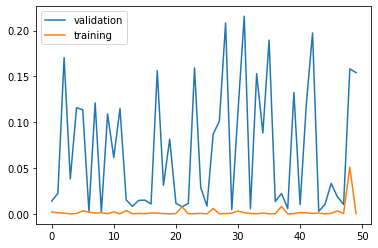

In [ ]:
plt.plot(val_loss, label = "validation")
plt.plot(train_loss, label = "training")
plt.legend()

During the training we have saved the model with the lowest loss, which for this traning is 0.00018. We will load it to use it on our test data set. 

In [ ]:
state_dict = torch.load('/content/Trained_model.pth')
print(state_dict.keys())

odict_keys(['encoder1.enc1conv1.weight', 'encoder1.enc1norm1.weight', 'encoder1.enc1norm1.bias', 'encoder1.enc1norm1.running_mean', 'encoder1.enc1norm1.running_var', 'encoder1.enc1norm1.num_batches_tracked', 'encoder1.enc1conv2.weight', 'encoder1.enc1norm2.weight', 'encoder1.enc1norm2.bias', 'encoder1.enc1norm2.running_mean', 'encoder1.enc1norm2.running_var', 'encoder1.enc1norm2.num_batches_tracked', 'encoder2.enc2conv1.weight', 'encoder2.enc2norm1.weight', 'encoder2.enc2norm1.bias', 'encoder2.enc2norm1.running_mean', 'encoder2.enc2norm1.running_var', 'encoder2.enc2norm1.num_batches_tracked', 'encoder2.enc2conv2.weight', 'encoder2.enc2norm2.weight', 'encoder2.enc2norm2.bias', 'encoder2.enc2norm2.running_mean', 'encoder2.enc2norm2.running_var', 'encoder2.enc2norm2.num_batches_tracked', 'encoder3.enc3conv1.weight', 'encoder3.enc3norm1.weight', 'encoder3.enc3norm1.bias', 'encoder3.enc3norm1.running_mean', 'encoder3.enc3norm1.running_var', 'encoder3.enc3norm1.num_batches_tracked', 'encoder

In [ ]:
model.load_state_dict(state_dict)
best_model = model.eval()
best_model = best_model.cuda()
print(best_model)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

# 4.Test the network on test data

Now we need to check if the network has learnt anything at all. We will check this by recreating the clean image that the neural network outputs, and checking it against the ground truth. Let us display some unseen images changing the contrast.

Desired images:


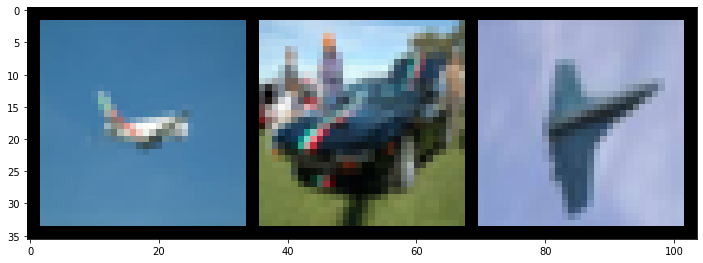

Input images with increased contrast: 


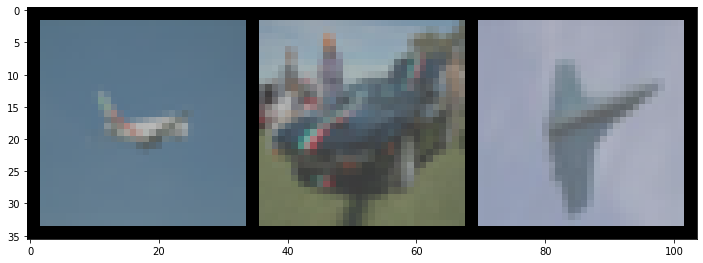

Reconstructed images with increased contrast: 


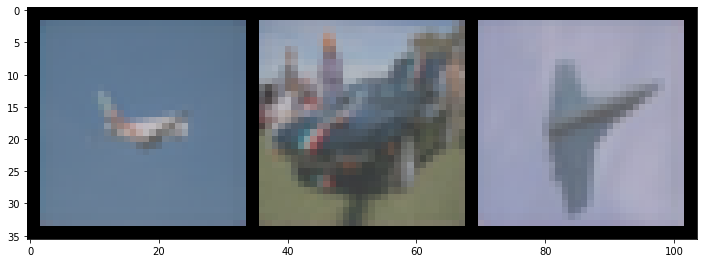

In [ ]:
images, _ = test_data_iter.next()
images.cuda()

print('Desired images:')
imshow(torchvision.utils.make_grid(images[:3]))
plt.show()

print('Input images with increased contrast: ')
transf_images = contrast(images)
imshow(torchvision.utils.make_grid(transf_images[:3]))
plt.show()

print('Reconstructed images with increased contrast: ')
outputs = best_model(transf_images.cuda()).cpu()

imshow(torchvision.utils.make_grid(outputs[:3]))

We now are checking on the brightness

Desired images:


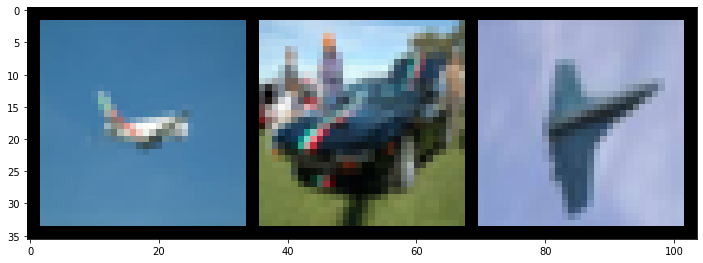

Input images with increased brightness: 


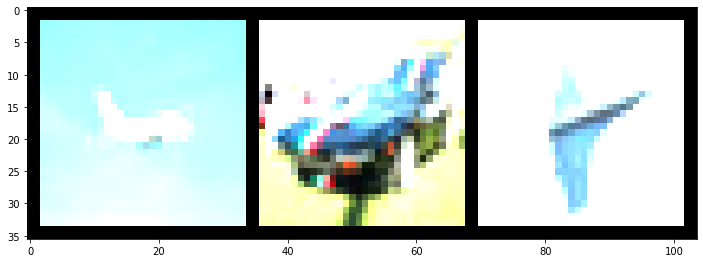

Reconstructed images with increased brightness: 


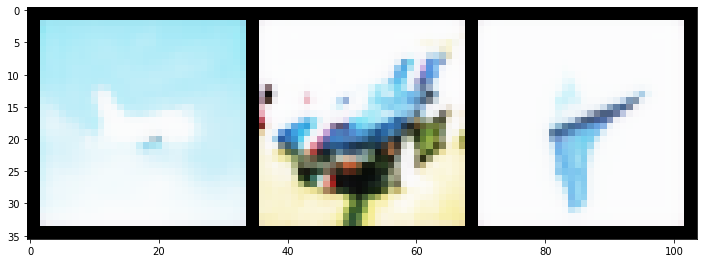

In [ ]:
images.cuda()

print('Desired images:')
imshow(torchvision.utils.make_grid(images[:3]))
plt.show()

print('Input images with increased brightness: ')
transf_images = brightness(images)
imshow(torchvision.utils.make_grid(transf_images[:3]))
plt.show()

print('Reconstructed images with increased brightness: ')
outputs = best_model(transf_images.cuda()).cpu()

imshow(torchvision.utils.make_grid(outputs[:3]))